# Análisis de Mercado

## Estudio y "predicción" de Apple en la bolsa de valores

Si se quiere estudiar el comportamiento de una empresa, sea Apple, en la bolsa de valores a lo largo de varios años para detectar comportamiento y fenómenos del mercado, se puede extraer su información y realizar el respectivo análisis de datos.

In [12]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import t
import numpy as np

In [13]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2021-01-01"

# Se descarga la información como un dataframe
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [14]:
# Primero se observa cómo está estructurada la información
print(data.head())

# Para analizarla, es importante saber que está completa
print(data.isnull().sum())

# En caso de valores no numéricos, se eliminan
data = data.dropna()


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.435270  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.746887  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.749125  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.082138  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.007429  237458000
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


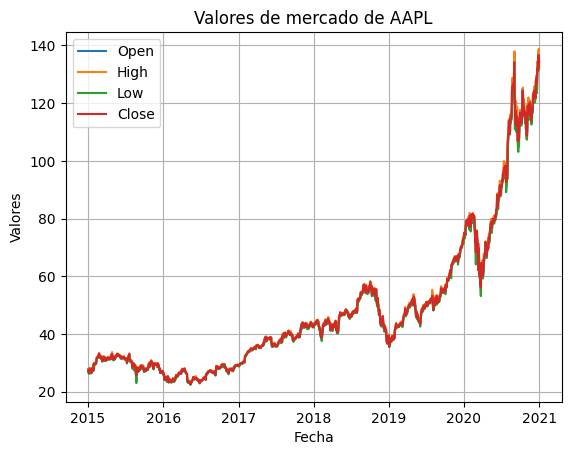

In [15]:
# Se puede graficar cómo se va comportando el valor de apertura, cierre, bajos y máximos respecto al tiempo

plt.plot(data.index, data['Open'], label='Open')
plt.plot(data.index, data['High'], label='High')
plt.plot(data.index, data['Low'], label='Low')
plt.plot(data.index, data['Close'], label='Close')

plt.title(f'Valores de mercado de {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.grid(True)
plt.legend()
plt.show()


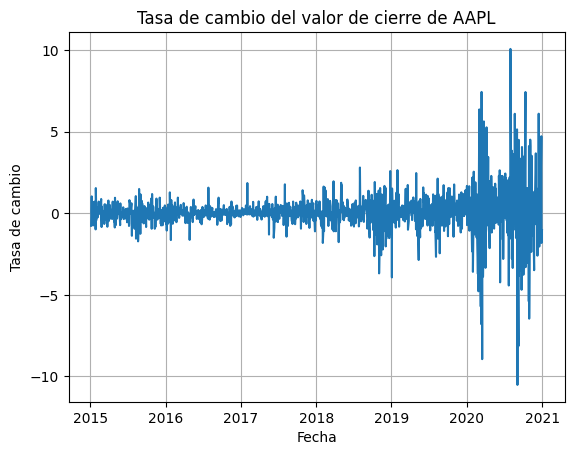

In [16]:
# Sabiendo esto, se puede calcular y agregar una columna que describa qué tan rápido suben o bajan estos valores de cierre por medio de su derivada

data['Close change'] = data['Close'].diff()
data.dropna(inplace=True)


plt.plot(data.index, data['Close change'])
plt.title(f'Tasa de cambio del valor de cierre de {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Tasa de cambio')
plt.grid(True)
plt.show()


Ya con esto se puede ir extrayendo información, por ejemplo, a partir de 2020 se empezó a ver un cambio más drástico entre los valores de cierre en días sucesivos. Por lo mismo, se puede intentar estudiar su distribución:

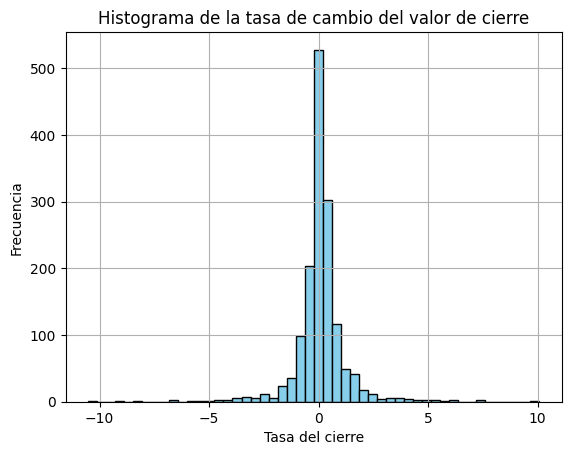

In [17]:
plt.hist(data['Close change'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma de la tasa de cambio del valor de cierre')
plt.xlabel('Tasa del cierre')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

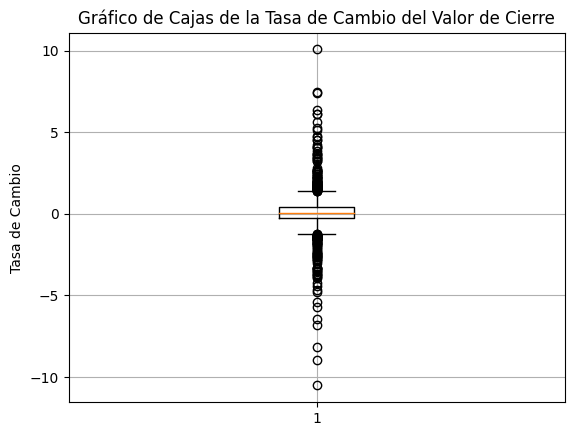

In [18]:
# Crear el gráfico de cajas
plt.boxplot(data['Close change'])
plt.title('Gráfico de Cajas de la Tasa de Cambio del Valor de Cierre')
plt.ylabel('Tasa de Cambio')
plt.grid(True)
plt.show()

Acá se observa que hay bastantes valores atípicos, lo cual es esperable de un sistema que en teoría no puede ser predecido a puntualidad.

Se observa además, que hay una distribución centrada en 0, con una variación estimada entre -5 y 5 que se asemeja mucho a una distribución t-Student. Por lo mismo, se puede emplear un ajuste a la distribución y el cálculo de sus parámetros:

Parámetros de la distribución t-Student:
Grados de libertad (df): 1.5405252499096687
Localización (loc): 0.04307475266533004
Escala (scale): 0.40331475514764914


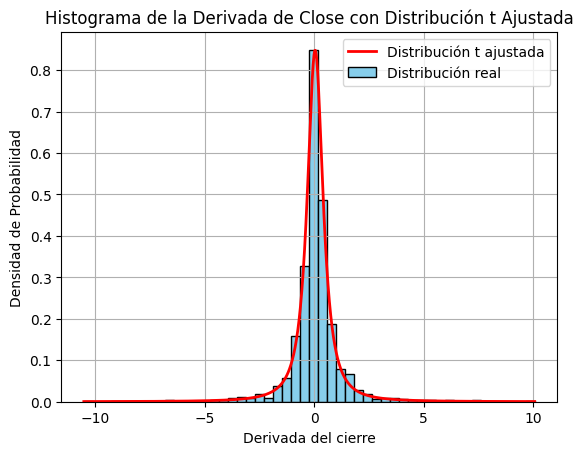

In [19]:
# Se emplea un ajuste por medio de la distribución t-Student
params = t.fit(data['Close change'])

# Se devuelven los parámetros ajustados
df, loc, scale = params
print("Parámetros de la distribución t-Student:")
print("Grados de libertad (df):", df)
print("Localización (loc):", loc)
print("Escala (scale):", scale)

# Se grafica el ajuste
x = np.linspace(data['Close change'].min(), data['Close change'].max(), 1000)
plt.plot(x, t.pdf(x, df, loc, scale), 'r-', lw=2, label='Distribución t ajustada')
plt.hist(data['Close change'], bins=50, density=True, color='skyblue', edgecolor='black', label='Distribución real')

plt.title('Histograma de la Derivada de Close con Distribución t Ajustada')
plt.xlabel('Derivada del cierre')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.grid(True)
plt.show()

Véase que esta función describe bastante bien la distribución de probabilidad del cambio del valor de cierre, con una forma bastante simétrica y muy punteada en el no cambio, con un ligera desviación a la derecha (0.04). Sin embargo, no es muy fiable dado que se calculan bajos grados de libertad, por lo que no sería un buen predictor. Sin embargo, por el gusto del arte, hagámoslo:

### ¡Predicción del mercado de valores!

Intentemos predecir a los siguientes 2 años (2021-2023) cómo se comportaría el cambio de los valores de cierre de Apple en el mercado. Esto se hace generando un número de sucesos aleatorios, 252 por cada año (por los días hábiles en que abre y cierra el mercado). Luego se generan los valores de prueba por medio de `t.rvs`. Además se pueden calcular los percentiles al 1% y 99%, que pueden ser útiles para estudiar la variabilidad de esta predicción. Finalmente se grafica esta predicción apendada.

Percentil 1%: -4.2450098239730005
Percentil 99%: 4.331159329303657


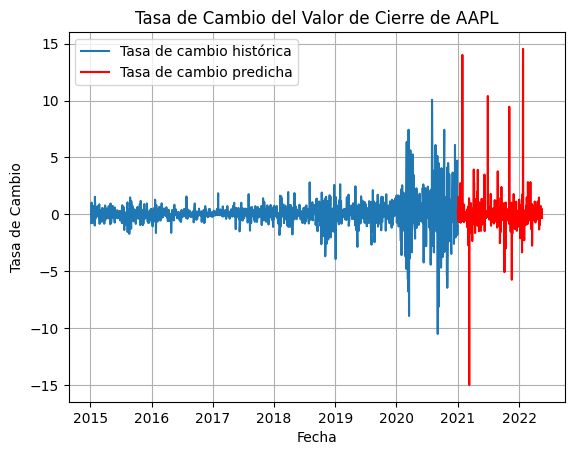

In [20]:
n_years = 2
max_change = 15

# Se generan muestras aleatorias basadas en la distribución t ajustada
n_samples = n_years * 252  # Suponiendo 252 días hábiles por año

samples = t.rvs(df, loc=loc, scale=scale, size=n_samples)
samples = np.clip(samples, -max_change, max_change)

# Se calculan los percentiles 1% y 99% de la distribución t ajustada
percentile_1 = t.ppf(0.01, df, loc=loc, scale=scale)
percentile_99 = t.ppf(0.99, df, loc=loc, scale=scale)

print("Percentil 1%:", percentile_1)
print("Percentil 99%:", percentile_99)

# Se grafica el histórico
plt.plot(data.index, data['Close change'], label='Tasa de cambio histórica')
plt.title(f'Tasa de Cambio del Valor de Cierre de {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Cambio')
plt.grid(True)

# Se trazan las muestras aleatorias
plt.plot(data.index[-1] + pd.to_timedelta(np.arange(n_samples), unit='D'), samples, 'r-', label='Tasa de cambio predicha')

plt.legend()
plt.show()

Ahora veamos si esta predicción se cumplió:

In [21]:
# Data hasta 2023

ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-01-01"
data_2023 = yf.download(ticker, start=start_date, end=end_date)
data_2023 = data_2023.dropna()
data_2023['Close change'] = data_2023['Close'].diff()
data_2023.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed


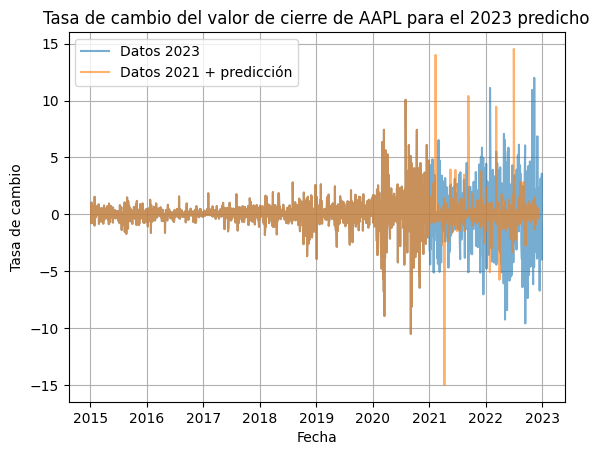

In [22]:
# Data hasta 2021 con predicción a 2023

# Limitar las muestras aleatorias dentro del rango de +-20 para recortar los anómalos
samples = np.clip(samples, -max_change, max_change)

# Se genera un índice de fechas para las muestras predichas
date_range = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_samples, freq='B')

# Se crea un DataFrame para las muestras predichas
predicted_data = pd.DataFrame({'Date': date_range, 'Close change': samples})
predicted_data.set_index('Date', inplace=True)

# Se fusionan los datos predichos con el DataFrame original
merged_data = pd.concat([data, predicted_data])


plt.plot(data_2023.index, data_2023['Close change'],alpha=0.6,label='Datos 2023')
plt.plot(merged_data.index, merged_data['Close change'],alpha=0.6,label='Datos 2021 + predicción')
plt.title(f'Tasa de cambio del valor de cierre de {ticker} para el 2023 predicho')
plt.xlabel('Fecha')
plt.ylabel('Tasa de cambio')
plt.grid(True)
plt.legend()
plt.show()


### Fracaso... ¡como era de esperar!

El mercado es un tema de estudio de muchísimo interés, financiero y matemático, lo cual nace de su propia naturaleza caótica. Sin embargo, con estas herramientas de análisis de datos podemos observar por nosotros mismos cómo de volátil es, y también estar más informados en qué podemos hacer con él, sus limitaciones y sus ventajas.